In [30]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

# Feature Selection Methods

The [sklearn.feature_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) module implements various feature selection algorithms. 

It currently includes univariate filter selection methods and the recursive feature elimination algorithm

https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection

## Prepare the data - Titanic Dataset

In [31]:
# load the dataset, using PassengerId as index
df_train = pd.read_csv("../../datasets/Titanic/train.csv", index_col='PassengerId')
df_train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Data variable descriptions:
<pre>
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5
</pre>

### Deal with NaN values

In [32]:
df_train.isna().sum().sort_values(ascending=False)

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
Survived      0
dtype: int64

We have NaN values, which we fill with some proper values, after getting some insight.

In [33]:
# # check what are the unique values in Cabin:
# print(df_train.Cabin.unique())

# # check what are the unique values in Age:
# print(df_train.Age.unique())
# print(df_train.Age.median())

# # check what are the unique values in Embarked:
# print(df_train.Embarked.unique())
# print(df_train.Embarked.value_counts()) 

In [34]:
# Put 'S' for 'Embarked' null values, as this value is most frequent:
df_train["Embarked"] = df_train["Embarked"].fillna("S")

# put the median passengers age for 'Age' null values
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].median())

# put some new value (like 'C0') for  all 'Cabin' null values
# check if the new value exists
# print('C0' in df_train.Cabin)

df_train["Cabin"] = df_train["Cabin"].fillna('C0')


### Replace string data with numbers

In [35]:
# helper function
def multiple_categories_to_numbers(s):
     # Get the unique values 
    unique_values = s.unique()

    # Generate a mapping of strings values to a numbers (0,1,...)    
    values_map = dict(zip(unique_values, range(0, len(unique_values) + 1)))    

    # Transform from a string to an integer number representation
    return s.map(values_map).astype(int)

In [36]:
df_train.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,C0,S


In [37]:
for column in df_train:
    if df_train[column].dtype == "object":        
        df_train[column] = multiple_categories_to_numbers(df_train[column])

# check the data
df_train.dtypes


Survived      int64
Pclass        int64
Name          int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Ticket        int64
Fare        float64
Cabin         int64
Embarked      int64
dtype: object

## Feature Selection

In [38]:
# Separate features from target
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']



### Removing features with low variance

sklearn.feature_selection - removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

In [39]:
from sklearn.feature_selection import VarianceThreshold

# show the variances for each column - maybe that help when choosing the treshold:
# print(X.var())

# select treshold
treshold = 0.9
sel = VarianceThreshold(threshold=treshold).fit(X)

# create a mask of features retained:
mask = sel.get_support()    

# show the retained columns names
retained_columns = X.columns[mask]    
print(retained_columns)


# if we are ok, we have to apply the transformation
# sel.transform(X)


Index(['Name', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin'], dtype='object')


### Feature Importance

Sex         0.272815
Age         0.127399
Fare        0.113616
Ticket      0.112629
Name        0.110286
Pclass      0.091228
Cabin       0.061281
SibSp       0.040909
Parch       0.036418
Embarked    0.033419
dtype: float64


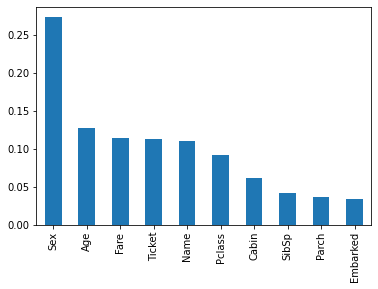

In [40]:
from sklearn.ensemble import ExtraTreesClassifier

sel = ExtraTreesClassifier()
sel.fit(X,y)

# compute the importance of each feature, sorted:
feat_importances = pd.Series(sel.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feat_importances)

#plot graph of feature importances
feat_importances.plot(kind='bar')
plt.show()


In [41]:
X = X.drop(axis=1,columns=['Name', 'Cabin', 'Parch', 'Embarked'] )

### Correlation Matrix with Heatmap

In [44]:
#get correlations of each features in dataset
corr_matrix = X.corr()

# plt.figure(figsize=(12,10))

# #plot with seaborn
# g=sns.heatmap(corrmat,annot=True,cmap="Reds")
print(corr_matrix)
for column in corr_matrix.columns:
    col_data = corr_matrix[column]
    print(column)
    
    for value in col_data:
        if abs(value) >0.3:
            print(value)


          Pclass       Sex       Age     SibSp    Ticket      Fare
Pclass  1.000000 -0.131900 -0.339898  0.083081 -0.017489 -0.549500
Sex    -0.131900  1.000000 -0.081163  0.114631 -0.132709  0.182333
Age    -0.339898 -0.081163  1.000000 -0.233296  0.119047  0.096688
SibSp   0.083081  0.114631 -0.233296  1.000000 -0.303229  0.159651
Ticket -0.017489 -0.132709  0.119047 -0.303229  1.000000 -0.142578
Fare   -0.549500  0.182333  0.096688  0.159651 -0.142578  1.000000
Pclass
1.0
-0.33989832839258516
-0.5494996199439061
Sex
1.0
Age
-0.33989832839258516
1.0
SibSp
1.0
-0.30322893233852155
Ticket
-0.30322893233852155
1.0
Fare
-0.5494996199439061
1.0


## Univariate Selection

Uses statistical tests to select those featuresm that have the strongest relationship with the output variable.
